# PyTorch Image Classifier

In [23]:
# libraries
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


First, we'll download and set up the dataset which PyTorch gives us:

In [25]:
# download dataset

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(training_data)
print('\n')
print(test_data)

100%|██████████| 26421880/26421880 [00:03<00:00, 6808833.02it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270821.96it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1384456.31it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6772985.25it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


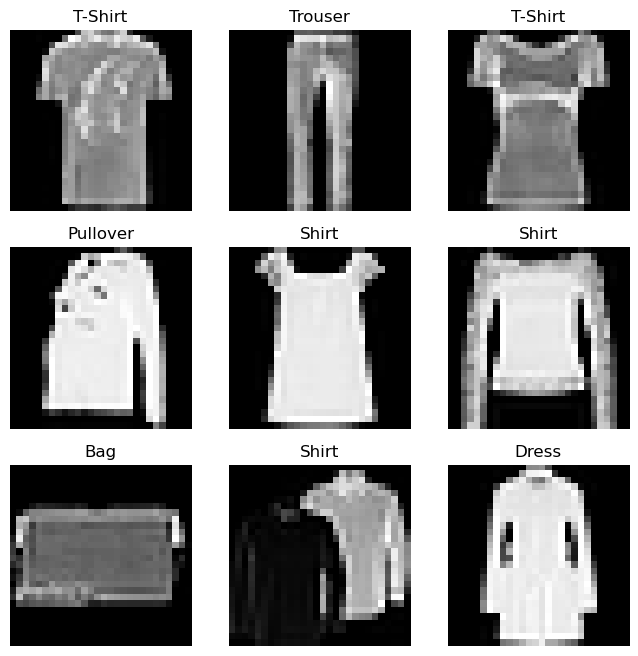

In [26]:
# visualize training dataset

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Our scaling study will test the speed and performance of the model through the usage of different numbers of gpus. To do this, we must set up the PyTorch architecture and the image classifier model:

In [28]:
# subset of dataset

trainloader = torch.utils.data.DataLoader(training_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [29]:
# set up devices

gpus = 1 # for command line argument: int(sys.argv[1]) if len(sys.argv) > 1 else -1
device_ids = list(range(gpus))

device = (
    "cuda:0" if torch.cuda.is_available() and gpus >= 0 else
    "cpu"
)

print(f"Using device: {device}")

Using device: cpu


In [32]:
# set up architecture

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

if gpus > 1:
    model = nn.DataParallel(model, device_ids=device_ids)

model.to(device)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


Most of the computational complexity lies within the training of the data:

In [35]:
%%time 
# train the model

# Define the loss
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 2.121245195870715
Training loss: 1.3857845961412132
Training loss: 0.9958685848758673
Training loss: 0.8410934983158925
Training loss: 0.7587639319617102
CPU times: user 1min 36s, sys: 1.24 s, total: 1min 37s
Wall time: 50.7 s


In [36]:
# test model

correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784).to(device)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, 
    # need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.7242


----